In [44]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import os

from src.beam import beam_arguments, Experiment, get_beam_parser
from src.beam import UniversalDataset, UniversalBatchSampler
from src.beam import Algorithm, PackedFolds
from src.beam import DataTensor, BeamOptimizer, beam_logger

from torchvision import transforms
import torchvision
from ray import tune

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Deep Learning Projects with Beam: a Step-by-Step Guide

In this tutorial we'll cover the best practices in building a new beam project. We'll go over all the essential steps when building a project from scratch and using both Jupyter and Pycharm as IDE and developement tools.

Usually, you'll get the most out of beam if you **build your project with beam** and avoid porting your existing project to beam. Therefore, we hope that after completing this guide, your first choice will always be to start a beam project from scratch. 

So, let's start.

For this tutorial we will use the CIFAR10 classification task.

Our steps will be:

1. Setting up an experiment. Optional: building an argument parser.
2. Building a Dataset.
3. Building a neural-net.
4. Writing an iteration loop.
5. Building an algorithm based on the iteration loop.
6. Training your algorithm with default parameters.
7. Optimizing your hyperparameters with the Study class.


## Setting up an experiment

Before setting up the experiment, lets define two directories: ```path_to_data``` which will contain the dataset information and ```root_dir``` which will contain the project results and log files

In [36]:
# path_to_data = '/localdata/elads/data/datasets/cifar10'
# root_dir = '/localdata/elads/data/cifar10'

path_to_data = '/home/shared/data/dataset/cifar10'
root_dir = '/home/shared/data/results/cifar10'

The beam experiment class object, deals with all the trifles, i.e., parts in the training process which are not directly related to algorithm. This includes:   
1. Storing the Hyperparameters.
2. Constructing the experimeny logging directory and storing the code, the trained model and a log file.
3. Printing results to the screen, storing them into the disk and sending them to a tensorboard writer.
4. managing parallel runs.

This design choice helps in maintaining a clean Algorithm class which is not linked to any particular experiment or even ש dataset and can be later directly shiped for deployment without any code refactoring.

Our very first beam object would be the experiment hyperparameters. Beam has a set of default hyperparamters and the user may extra hyperparamters on top. If we work in a jupyter notebook, we call ```beam_arguments``` to generate the hyperparameter object. When working natively with python it is best to set the hyperparameters as script arguments.

In [50]:
hparams = beam_arguments()

User can set existing hyperparameters by passing them as strings or named arguments to the ```beam_arguments``` function. You can also dynamically define new arguments. In the following example we added a few parameters such as ```channels``` and ```activation``` which we are going to use later in our algorithm.

In [51]:
hparams = beam_arguments(f"--project-name=cifar10 --root-dir=/tmp/cifar --algorithm=CIFAR10Algorithm --device=0 --amp --lr-d=1e-2 --batch-size=512",
                      "--n-epochs=40 --clip-gradient=1000 --parallel=0 --accumulate=1 --no-deterministic",
                      "--weight-decay=3e-5 --beta1=0.9", 
                      path_to_data=path_to_data, dropout=.0, activation='relu', channels=1024, label_smoothing=.2,
                      padding=6, gain=.2, turn_point=512, final_point=4096, minimal_gain=.05, temperature=0.05)

In [52]:
hparams

Namespace(accumulate=1, activation='relu', algorithm='CIFAR10Algorithm', amp=True, batch_size=512, batch_size_eval=None, batch_size_train=None, beta1=0.9, beta2=0.999, channels=1024, clip_gradient=1000.0, cpu_workers=0, deterministic=False, device='0', dropout=0.0, enable_tqdm=True, epoch_length=None, epoch_length_eval=None, epoch_length_train=None, eps=0.0001, expansion_size=10000000, final_point=4096, gain=0.2, half=False, identifier='debug', init='ortho', label_smoothing=0.2, lognet=True, lr_dense=0.01, lr_sparse=0.01, minimal_gain=0.05, mp_port='random', n_epochs=40, override=False, oversample=False, oversampling_weight_factor=1.0, padding=6, parallel=0, path_to_data='/home/shared/data/dataset/cifar10', print_results=True, project_name='cifar10', reload=False, resume=-1, root_dir='/tmp/cifar', scale_epoch_by_batch_size=True, seed=0, split_dataset_seed=5782, store_initial_weights=False, store_networks='logscale', store_results='logscale', temperature=0.05, tensorboard=True, total_st

Based on the generated hyperparameters, we can set up a new experiment:

In [55]:
experiment = Experiment(hparams)

2022-07-11 13:50:33 | INFO     | Creating new experiment
2022-07-11 13:50:33 | INFO     | Experiment directory is: /tmp/cifar/cifar10/CIFAR10Algorithm/debug/0003_20220711_135033
2022-07-11 13:50:33 | INFO     | beam project: cifar10
2022-07-11 13:50:33 | INFO     | Experiment Hyperparameters
2022-07-11 13:50:33 | INFO     | project_name: cifar10
2022-07-11 13:50:33 | INFO     | algorithm: CIFAR10Algorithm
2022-07-11 13:50:33 | INFO     | identifier: debug
2022-07-11 13:50:33 | INFO     | mp_port: random
2022-07-11 13:50:33 | INFO     | root_dir: /tmp/cifar
2022-07-11 13:50:33 | INFO     | reload: False
2022-07-11 13:50:33 | INFO     | resume: -1
2022-07-11 13:50:33 | INFO     | override: False
2022-07-11 13:50:33 | INFO     | cpu_workers: 0
2022-07-11 13:50:33 | INFO     | device: 0
2022-07-11 13:50:33 | INFO     | parallel: 0
2022-07-11 13:50:33 | INFO     | tensorboard: True
2022-07-11 13:50:33 | INFO     | lognet: True
2022-07-11 13:50:33 | INFO     | deterministic: False
2022-07-11

While we can dynamically add as much parameters as we wish, it is best if we set default values (and optionally help strings) to each parameter that we define in our experiment. For this purpose we need to define a new parser on top of the default parser and call ```beam_arguments``` with the first argument as the new parser

In [58]:
def get_cifar10_parser():

    parser = get_beam_parser()
    parser.add_argument('--path-to-data', type=str, default='/home/shared/data/dataset/cifar10', help='Where to store the dataset')
    parser.add_argument('--dropout', type=float, default=0.0, help='Dropout value for the feature layer')
    parser.add_argument('--activation', type=str, default='relu', help='Type of activation function. supported types: [relu, celu, gelu]')
    parser.add_argument('--channels', type=int, default=1024, help='Final channel size in the convolution stack')
    parser.add_argument('--label-smoothing', type=float, default=0.2, help='a label_smoothing factor for the CrossEntropy loss')
    parser.add_argument('--temperature', type=float, default=0.05, help='a softmax temperature scaling')
    parser.add_argument('--padding', type=int, default=6, help='Padding number for the crop augmentation')
    parser.add_argument('--gain', type=float, default=0.2, help='a gain factor for the learning rate scheduler')
    parser.add_argument('--turn-point', type=int, default=512, help='a turn_point factor for the learning rate scheduler')
    parser.add_argument('--final-point', type=int, default=4096, help='a final_point factor for the learning rate scheduler')
    parser.add_argument('--minimal-gain', type=float, default=0.05, help='a minimal_gain factor for the learning rate scheduler')

    return parser

In [59]:
hparams = beam_arguments(get_cifar10_parser(), f"--project-name=cifar10 --root-dir=/tmp/cifar --algorithm=CIFAR10Algorithm --device=0 --amp --lr-d=1e-2 --batch-size=512",
                      "--n-epochs=40 --clip-gradient=1000 --parallel=0 --accumulate=1 --no-deterministic",
                      "--weight-decay=3e-5 --beta1=0.9")

## Building a dataset

As usual we'll start with exploring the data. This time we can use torchvision to download the data.

In [61]:
path_to_data = '/localdata/elads/data/datasets/cifar10'
dataset = torchvision.datasets.CIFAR10(root=path_to_data, train=True, transform=torchvision.transforms.PILToTensor(), download=True)

Files already downloaded and verified


Here we used the ```torchvision.transforms.PILToTensor``` to transform the PIL image to tensor. Lets take for example the first image and print its associated label and shape

In [62]:
img, label = dataset[0]
print(label)
print(img.shape)

6
torch.Size([3, 32, 32])


Lets plot the image with matplotlib:

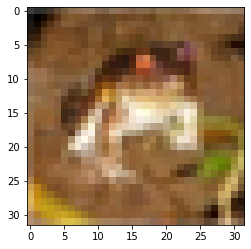

In [63]:
plt.imshow(img.permute(1, 2, 0).numpy())

Now we are ready to build our very first beam object which is the Dataset. We start by building a prototype in the notebook and later we will save it into the project .py file

First, instead of downloading and preprocessing the data each time, we will store a tensor version of both the train and the test parts of the data. If the file exists, we will directly read the data from the disk. if not, we download it and store the downloaded data as torch pickled object.

In [64]:
path = path_to_data
device = torch.device(0)

file = os.path.join(path, 'dataset_uint8.pt')
if os.path.exists(file):
    x_train, x_test, y_train, y_test = torch.load(file, map_location=device)

else:
    dataset_train = torchvision.datasets.CIFAR10(root=path, train=True,
                                                 transform=torchvision.transforms.PILToTensor(), download=True)
    dataset_test = torchvision.datasets.CIFAR10(root=path, train=False,
                                                transform=torchvision.transforms.PILToTensor(), download=True)

    x_train = torch.stack([dataset_train[i][0] for i in range(len(dataset_train))]).to(device)
    x_test = torch.stack([dataset_test[i][0] for i in range(len(dataset_test))]).to(device)

    y_train = torch.LongTensor(dataset_train.targets).to(device)
    y_test = torch.LongTensor(dataset_test.targets).to(device)

    torch.save((x_train, x_test, y_train, y_test), file)

In [65]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(x_train.device, x_test.device, y_train.device, y_test.device)
print(x_train.dtype, x_test.dtype, y_train.dtype, y_test.dtype)

torch.Size([50000, 3, 32, 32]) torch.Size([10000, 3, 32, 32]) torch.Size([50000]) torch.Size([10000])
cuda:0 cuda:0 cuda:0 cuda:0
torch.uint8 torch.uint8 torch.int64 torch.int64


The Beam Dataset object, works best with a single one-dimentional index to fetch elements from the dataset. However, in our case, we have two objects, the train and the test part. A simple solution could be to concatenate them together:

In [66]:
data = torch.cat([x_train, x_test])
labels = torch.cat([y_train, y_test])
test_indices = len(x_train) + torch.arange(len(x_test))

In this example, we also calculated the test_indices which we would like to store in order to fetch test examples.

While this solution is plausable, Beam is even more fun as it contains a PackedFolds object which is able to hold and index together multiple objects which may have different size. We can use the PackedFolds object to hold the two dataset parts, and calculate the test indices:

In [67]:
data = PackedFolds({'train': x_train, 'test': x_test})
labels = PackedFolds({'train': y_train, 'test': y_test})
test_indices = labels['test'].index

we can use the PackedFolds object to access each part of the dataset

In [68]:
data['train'].shape

torch.Size([50000, 3, 32, 32])

We can fetch and slice the data with its indices as a normal tensor. Reffer to the PackedFolds tutorial for further explenations and examples.

In [69]:
labels

{'train': tensor([6, 9, 9,  ..., 9, 1, 1]), 'test': tensor([3, 8, 8,  ..., 5, 1, 7])}

In [70]:
labels['test']

tensor([3, 8, 8,  ..., 5, 1, 7])

In [71]:
labels[40000:60000]

tensor([1, 8, 5,  ..., 5, 1, 7])

Lets build a first version of our dataset, without augmentations. We are required to write the ```__getitem__``` method that samples batches from the data for a given index vector

In [73]:
class CIFAR10Dataset(UniversalDataset):

    def __init__(self, hparams):
        
        path = hparams.path_to_data
        device = hparams.device
        
        super().__init__()

        file = os.path.join(path, 'dataset_uint8.pt')
        if os.path.exists(file):
            x_train, x_test, y_train, y_test = torch.load(file, map_location=device)

        else:
            dataset_train = torchvision.datasets.CIFAR10(root=path, train=True,
                                                         transform=torchvision.transforms.PILToTensor(), download=True)
            dataset_test = torchvision.datasets.CIFAR10(root=path, train=False,
                                                        transform=torchvision.transforms.PILToTensor(), download=True)

            x_train = torch.stack([dataset_train[i][0] for i in range(len(dataset_train))]).to(device)
            x_test = torch.stack([dataset_test[i][0] for i in range(len(dataset_test))]).to(device)

            y_train = torch.LongTensor(dataset_train.targets).to(device)
            y_test = torch.LongTensor(dataset_test.targets).to(device)

            torch.save((x_train, x_test, y_train, y_test), file)


        self.data = PackedFolds({'train': x_train, 'test': x_test})
        self.labels = PackedFolds({'train': y_train, 'test': y_test})

    def __getitem__(self, index):

        x = self.data[index]

        return {'x': x, 'y': self.labels[index]}

Notice that we passed ```hparams``` as an argument to the Dataset constructor. This will be our standard ```__init__``` format when working with beam, i.e. we pass all the arguments for the dataset in the ```hparams``` container. Now, lets make sure that we can sample a batch from this dataset:

In [78]:
dataset = CIFAR10Dataset(path_to_data, device)

In [79]:
d = dataset[10:20]
print({k: v.shape for k, v in d.items()})

{'x': torch.Size([10, 3, 32, 32]), 'y': torch.Size([10])}


while the objects ```dataset.data``` and ```dataset.labels``` contain two folds, i.e. train and test, the dataset still is not aware of the different folds and their meaning. In addition, we usually would like to split the train subset into a train-validation sets. For the dataset split purposes, beam datasets have the split method which is able to split/random split/time based split your data. It also requires a seed to generate reproducable splits. In our case, to allot 20% of the examples to the validation subset, we will call the split method as follows:

In [80]:
seed = 5782

dataset.split(validation=.2, test=dataset.labels['test'].index, seed=seed)

Now the dataset contains the ```indices_split``` dictionary which holds all the different subsets. They will be used to further generate samplers and dataloaders to iterate over the data.

In [81]:
print({k: len(v) for k, v in dataset.indices_split.items()})


{'test': 10000, 'validation': 12000, 'train': 38000}


In addition we can define different augmentations for the train/eval parts of the training. A nice property of the Beam dataset when combined with Beam algorithm is that like neural networks, it holds the ```training``` boolean property which sets the dataset in train/eval mode. The algorithm iterator toggles this property between train and eval sessions by calling ```dataset.train()``` or ```dataset.eval()``` (as with ```nn.Module``` objects). We can use this property to define different augmentations for each case.

In [86]:
class CIFAR10Dataset(UniversalDataset):

    def __init__(self, hparams, use_folds=True):
        super().__init__()

        path = hparams.path_to_data
        device = hparams.device
        padding = hparams.padding

        augmentations = transforms.Compose([transforms.RandomHorizontalFlip(),
                                            transforms.RandomCrop(32, padding=padding, padding_mode='edge'),])

        self.t_basic = transforms.Compose([transforms.Lambda(lambda x: (x / 255)),
                                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

        self.t_train = transforms.Compose([augmentations, self.t_basic])

        file = os.path.join(path, 'dataset_uint8.pt')
        if os.path.exists(file):
            x_train, x_test, y_train, y_test = torch.load(file, map_location=device)

        else:
            dataset_train = torchvision.datasets.CIFAR10(root=path, train=True,
                                                         transform=torchvision.transforms.PILToTensor(), download=True)
            dataset_test = torchvision.datasets.CIFAR10(root=path, train=False,
                                                        transform=torchvision.transforms.PILToTensor(), download=True)

            x_train = torch.stack([dataset_train[i][0] for i in range(len(dataset_train))]).to(device)
            x_test = torch.stack([dataset_test[i][0] for i in range(len(dataset_test))]).to(device)

            y_train = torch.LongTensor(dataset_train.targets).to(device)
            y_test = torch.LongTensor(dataset_test.targets).to(device)

            torch.save((x_train, x_test, y_train, y_test), file)

        if use_folds:
            self.data = PackedFolds({'train': x_train, 'test': x_test})
            self.labels = PackedFolds({'train': y_train, 'test': y_test})
            self.split(validation=.2, test=self.labels['test'].index, seed=experiment.args.split_dataset_seed)
        
        else:
            self.data = torch.cat([x_train, x_test])
            self.labels = torch.cat([y_train, y_test])
            test_indices = len(x_train) + torch.arange(len(x_test))
            self.split(validation=.2, test=test_indices, seed=hparams.split_dataset_seed)

    def __getitem__(self, index):

        x = self.data[index]

        if self.training:
            x = self.t_train(x)
        else:
            x = self.t_basic(x)

        x = x.to(memory_format=torch.channels_last)

        return {'x': x, 'y': self.labels[index]}

Notice, that we also added the ```hparams.device``` argument which defines the device for storing ```torch.Tensor``` objects in this experiemnt. Therefore, we map the data to the designated device. Finally, we added an option to work with simple tensors instead of ```PackedFolds```.

It is important to measure the fetching speed from the dataset. The most straitforward way to obtain that would be with ```tqdm```:

In [102]:
try

ValueError: could not convert string to float: '[0]'

In [92]:
type(torch.device(0))

torch.device

In [87]:
dataset = CIFAR10Dataset(hparams, use_folds=True)

RuntimeError: don't know how to restore data location of torch._UntypedStorage (tagged with 0)